In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf

In [2]:
data = pd.read_csv('data_stocks.csv')
data.shape

(41266, 502)

In [3]:
data = data.drop(['DATE'], axis=1)
data.shape

(41266, 501)

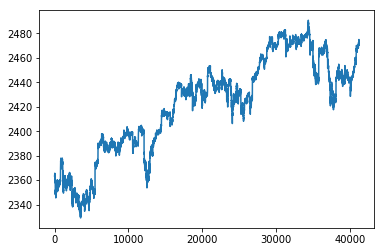

In [4]:
plt.plot(data['SP500'])
plt.show()

In [5]:
original_data = data
data = data.values

In [6]:
data.shape
n = data.shape[0]
p = data.shape[1]

In [7]:
train_start = 0
train_end = int(np.floor(0.8*n))
test_start = train_end
test_end = n

In [8]:
data_train = data[np.arange(train_start,train_end)]

In [9]:
data_test = data[np.arange(test_start, test_end)]

In [10]:
# Scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# When performing time series forecasting in real life, 
# you do not have information from future observations at 
# the time of forecasting. Therefore, calculation of scaling 
# statistics has to be conducted on training data and must 
# then be applied to the test data. Otherwise, you use 
# future information at the time of forecasting which 
# commonly biases forecasting metrics in a positive 
# direction.
scaler.fit(data_train)

data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

In [11]:
# layer_config = [n_input, 200, 200, 200, 200, n_classes]
# for i in range(1, len(layer_config)):
#     print i

In [12]:
#  layer_config takes the form: [n_input, 200, 200, 200, 200, n_classes]
# Here 5 layers will be added

def custom_add_layers(x, layer_config, name="Neural_Net"):
    
    layers = {}
    layers_compute = {}

    with tf.name_scope(name):
        for i in range(1, len(layer_config)):
            new_layer = {'weights': tf.Variable(tf.random_normal([layer_config[i-1],layer_config[i]],mean=0,stddev=0.1)),
                        'biases': tf.Variable(tf.random_normal([layer_config[i]], mean=0, stddev=0.1))}
            layers[i-1] = new_layer

            with tf.name_scope("weights"):
                tf.summary.histogram("w_"+str(i)+"_summary", new_layer['weights'])

            with tf.name_scope("biases"):
                tf.summary.histogram("b_"+str(i)+"_summary", new_layer['biases'])

            l = tf.add(tf.matmul(x if i == 1 else layers_compute[i-2], layers[i-1]['weights']), layers[i-1]['biases'])
            
            with tf.name_scope(name):
                l = tf.nn.relu(l) if i != len(layer_config)-1 else l

            layers_compute[i-1] = l

    lastlayer = len(layers_compute)-1
    return layers_compute[lastlayer]
# last layer ka output wapis bhej dia
# Add DROPOUT AT LAST

In [13]:
# Build X and y
X_train = data_train[:, 1:]
y_train = data_train[:, 0]
X_test = data_test[:, 1:]
y_test = data_test[:, 0]

In [14]:
print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape

(33012, 500)
(33012,)
(8254, 500)
(8254,)


In [15]:
# Model architecture parameters
n_stocks = X_train.shape[1]
n_target = 1

# Placeholder used to store input, target data in the graph
# Placeholders are kind of hyperparameters

# none,n_stocks means rows or instances can vary but 
# coloumns or features will be the same
X = tf.placeholder(dtype=tf.float32, shape=[None, n_stocks])

# none means the same as above: instances can vary
Y = tf.placeholder(dtype=tf.float32, shape=[None])

# Output layer (must be transposed)
out = custom_add_layers(x=X,layer_config=[n_stocks, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, n_target])

# Cost function
# The cost function of the network is used to generate a measure of 
# deviation between the network’s predictions and the actual observed 
# training targets. For regression problems, the mean squared error (MSE) 
# function is commonly used. MSE computes the average squared deviation between 
# predictions and targets. Basically, any differentiable function can be implemented 
# in order to compute a deviation measure between predictions and targets.
mse = tf.reduce_mean(tf.squared_difference(out, Y))

# Optimizer
# The optimizer takes care of the necessary computations that are used to adapt the network’s 
# weight and bias variables during training. Those computations invoke the calculation of so 
# called gradients, that indicate the direction in which the weights and biases have to be 
# changed during training in order to minimize the network’s cost function. The development 
# of stable and speedy optimizers is a major field in neural network an deep learning research.
opt = tf.train.AdamOptimizer().minimize(mse)
# Adam stands for “Adaptive Moment Estimation” and can be considered as a combination between 
# two other popular optimizers AdaGrad and RMSProp.

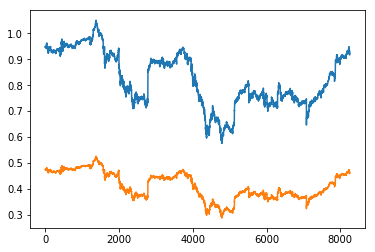

Epoch: 1 cost= 0.006766880189445601
Epoch: 2 cost= 0.010405013679530839
Epoch: 3 cost= 0.010776910053863276
Epoch: 4 cost= 0.004608106931442535
Epoch: 5 cost= 0.0030157758356210707
Epoch: 6 cost= 0.0025574973453217353
Epoch: 7 cost= 0.0022362240386542
Epoch: 8 cost= 0.0032711566135503745
Epoch: 9 cost= 0.0025323892336643894
Epoch: 10 cost= 0.002684058244511789
Epoch: 11 cost= 0.0047897112427222055
Epoch: 12 cost= 0.002871088378725517
Epoch: 13 cost= 0.0026560105957287306
Epoch: 14 cost= 0.002873178683472588
Epoch: 15 cost= 0.0031645252713019545
Epoch: 16 cost= 0.00467328437383685
Epoch: 17 cost= 0.006345357293724874
Epoch: 18 cost= 0.012248384817439728
Epoch: 19 cost= 0.0075476818651623034
Epoch: 20 cost= 0.012584370661443245
Epoch: 21 cost= 0.008218036077323632
Epoch: 22 cost= 0.006186537689728766
Epoch: 23 cost= 0.0059079992293220585
Epoch: 24 cost= 0.0046902923315030876
Epoch: 25 cost= 0.005544373211080256
Epoch: 26 cost= 0.00360690857067425
Epoch: 27 cost= 0.0035389624639776684
Epo

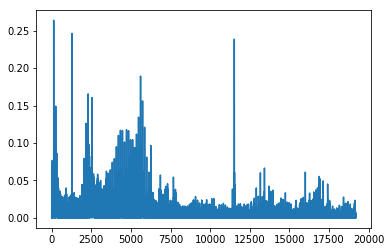

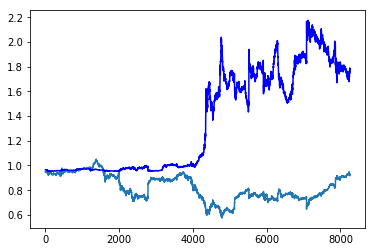

In [17]:
net = tf.Session()

# Make Session
# net = tf.Session()

# Run initializer
net.run(tf.global_variables_initializer())

# Setup interactive plot
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test)
line2, = ax1.plot(y_test*0.5)
plt.show()

# Number of epochs and batch size
epochs = 150
batch_size = 256
# batch_size = len(y_train)
net_loss=[]
for e in range(epochs):

#     # Shuffle training data
#     shuffle_indices = np.random.permutation(np.arange(len(y_train)))
#     X_train = X_train[shuffle_indices]
#     y_train = y_train[shuffle_indices]
    overall_loss = 0
    # Minibatch training
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = X_train[start:start + batch_size]
        batch_y = y_train[start:start + batch_size]
        # Run optimizer with batch
        _,loss = net.run([opt,mse],feed_dict={X: batch_x, Y: batch_y})
        net_loss.append(loss)
        # Show progress
        #if np.mod(i, 5) == 0:
            # Prediction
            #pred = net.run(mse, feed_dict={X: X_test})
            #line2.set_ydata(loss)
            #plt.plot(loss)
            #plt.title('Epoch ' + str(e) + ', Batch ' + str(i))
            #file_name = 'img/epoch_' + str(e) + '_batch_' + str(i) + '.jpg'
            #plt.savefig(file_name)
            #plt.show()
            #plt.pause(0.01)
        overall_loss += loss/batch_size
        #print "Epoch:", e+1, "cost=", loss
    print "Epoch:", e+1, "cost=", overall_loss

plt.plot(net_loss)
# Print final MSE after Training
# mse_final = net.run(mse, feed_dict={X: X_test, Y: y_test})

temp = net.run(out, feed_dict={X: X_test, Y: y_test})

plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test)
line2, = ax1.plot(temp,color='b')
plt.show()


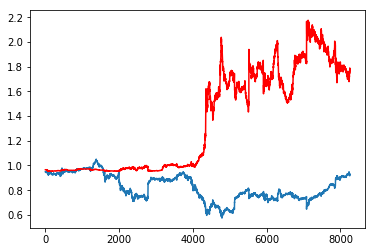

In [18]:
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test)
line2, = ax1.plot(temp,color='r')
plt.show()

In [ ]:
# Vvariables are used as flexible containers within the 
# graph that are allowed to change during graph execution. 
# Weights and biases are represented as variables in order 
# to adapt during training. Variables need to be initialized,
# prior to model training.